Install dependencies

In [ ]:
pip install pandas matplotlib seaborn

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import calendar
import numpy as np

# Set display options to ensure all columns are shown
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Function to determine the actual outcome of a game
def determine_actual_outcome(row):
    if row['homeGoals'] > row['awayGoals']:
        return 'H'  # Home win
    elif row['homeGoals'] < row['awayGoals']:
        return 'A'  # Away win
    else:
        return 'D'  # Draw


# Function to determine the expected outcome based on the lowest bookie coefficient
def determine_expected_outcome(row):
    odds = {
        'H': min(row['B365H'], row['BWH'], row['IWH'], row['PSH'], row['WHH'], row['VCH'], row['PSCH']),
        'D': min(row['B365D'], row['BWD'], row['IWD'], row['PSD'], row['WHD'], row['VCD'], row['PSCD']),
        'A': min(row['B365A'], row['BWA'], row['IWA'], row['PSA'], row['WHA'], row['VCA'], row['PSCA'])
    }
    return min(odds, key=odds.get)  # Return the key with the lowest value


def plot_unexpected_games(unexpected_games_sorted, team, criteria):
    # Assuming you have your dataframe ready as 'unexpected_games_sorted'
    # Group by league and season and count the number of unexpected results
    grouped_data = unexpected_games_sorted.groupby(['leagueName', 'season']).size().reset_index(name='count')

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x='season', y='count', hue='leagueName', data=grouped_data)
    plt.title('Unexpected Results by League and Season')
    plt.title(f"Unexpected games for {team} when they played {criteria}:")
    plt.xlabel('Season')
    plt.ylabel('Number of Unexpected Results')
    plt.xticks(rotation=45)
    plt.legend(title='League')
    plt.tight_layout()
    plt.show()


def plot_monthly_charts(unexpected_games_sorted):
    # Extract month from the date
    unexpected_games_sorted['month'] = pd.to_datetime(unexpected_games_sorted['date']).dt.month
    unexpected_games_sorted['month_name'] = unexpected_games_sorted['month'].apply(lambda x: calendar.month_name[x])

    # Iterate over each league
    for league in unexpected_games_sorted['leagueName'].unique():
        plt.figure(figsize=(12, 8))

        # Get data for the current league
        league_data = unexpected_games_sorted[unexpected_games_sorted['leagueName'] == league]

        # Iterate over each season in the current league
        for season in league_data['season'].unique():
            # Filter data for the current season
            season_data = league_data[league_data['season'] == season]

            # Group by month and count the number of unexpected results
            monthly_data = season_data.groupby('month_name').size().reset_index(name='count')

            # Sort the data by month
            monthly_data['month'] = monthly_data['month_name'].apply(lambda x: list(calendar.month_name).index(x))
            monthly_data.sort_values('month', inplace=True)

            # Plot a line for the current season
            plt.plot(monthly_data['month_name'], monthly_data['count'], label=season)

        # Finalizing the plot for the current league
        plt.title(f'Unexpected Results by Month for {league}')
        plt.xlabel('Month')
        plt.ylabel('Number of Unexpected Results')
        plt.xticks(rotation=45)
        plt.legend(title='Season')
        plt.tight_layout()
        plt.show()


def plot_profit_loss_chart(seasons, regular_profit_loss, catchup_profit_loss, lowest_balance):
    # Creating bars for the grouped bar chart
    bar_width = 0.35
    index = np.arange(len(seasons))

    fig, ax1 = plt.subplots()

    # Plotting bars for regular and catch-up strategy profits/losses
    ax1.bar(index - bar_width/2, regular_profit_loss, bar_width, label='Regular Strategy', color='blue')
    ax1.bar(index + bar_width/2, catchup_profit_loss, bar_width, label='Catch-Up Strategy', color='orange')

    ax1.set_xlabel('Seasons')
    ax1.set_ylabel('Profit/Loss ($)', color='blue')
    ax1.set_title('Profit/Loss and Lowest Balance by Betting Strategy per Season')
    ax1.set_xticks(index)
    ax1.set_xticklabels(seasons)
    ax1.legend(loc='upper left')

    # Plotting lowest balance on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(index, lowest_balances, color='green', marker='o', label='Lowest Balance (Catch-Up)')
    ax2.set_ylabel('Lowest Balance ($)', color='green')
    ax2.legend(loc='upper right')

    # Adjust the secondary y-axis scale if necessary
    ax2.set_ylim([min(lowest_balances) - 100, max(lowest_balances) + 100])

    plt.show()


def get_unexpected_games(team_name='Barcelona', mode='better'):
    # Load the dataset
    games_df = pd.read_csv('sample_data/games.csv')

    team_names_df = pd.read_csv('sample_data/teams.csv')
    league_names_df = pd.read_csv('sample_data/leagues.csv')

    games_df = games_df.merge(team_names_df, left_on='homeTeamID', right_on='teamID', how='left')
    games_df = games_df.rename(columns={'name': 'homeTeamName'}).drop('teamID', axis=1)
    games_df = games_df.merge(team_names_df, left_on='awayTeamID', right_on='teamID', how='left')
    games_df = games_df.rename(columns={'name': 'awayTeamName'}).drop('teamID', axis=1)

    games_df = games_df.merge(league_names_df, left_on='leagueID', right_on='leagueID', how='left')
    games_df = games_df.rename(columns={'name': 'leagueName'}).drop('leagueID', axis=1)

    if team_name:
        team_games_df = games_df[(games_df['homeTeamName'] == team_name) | (games_df['awayTeamName'] == team_name)].copy()
    else:
        team_games_df = games_df.copy()

    # Apply functions to determine actual and expected outcomes
    team_games_df['ActualOutcome'] = team_games_df.apply(determine_actual_outcome, axis=1)
    team_games_df['ExpectedOutcome'] = team_games_df.apply(determine_expected_outcome, axis=1)

    # Filter based on mode
    if mode == 'better':
        # Team won unexpectedly
        unexpected_games = team_games_df[
            (team_games_df['ActualOutcome'] == 'H') & (team_games_df['ExpectedOutcome'] != 'H') & (
                        team_games_df['homeTeamName'] == team_name) |
            (team_games_df['ActualOutcome'] == 'A') & (team_games_df['ExpectedOutcome'] != 'A') & (
                        team_games_df['awayTeamName'] == team_name)]
    elif mode == 'worse':
        # Team lost or drew unexpectedly
        unexpected_games = team_games_df[
            (team_games_df['ActualOutcome'] != 'H') & (team_games_df['ExpectedOutcome'] == 'H') & (
                        team_games_df['homeTeamName'] == team_name) |
            (team_games_df['ActualOutcome'] != 'A') & (team_games_df['ExpectedOutcome'] == 'A') & (
                        team_games_df['awayTeamName'] == team_name)]
    else:
        unexpected_games = team_games_df[team_games_df['ActualOutcome'] != team_games_df['ExpectedOutcome']]

    # Optionally, sort the unexpected games by date for chronological order
    unexpected_games_sorted = unexpected_games.sort_values(by='date')
    return unexpected_games_sorted


team_name = 'Barcelona'
seasons = [2015, 2016, 2014, 2017, 2018, 2019, 2020]
pd.set_option('display.max_rows', None)  # Set to display all rows
for criteria in ["better", "worse"]:
    games = get_unexpected_games(team_name, mode=criteria)
    print(f"Unexpected games for {team_name} when they played {criteria}:")
    print(games.loc[:,
          ['date', 'leagueName', 'homeTeamName', 'awayTeamName', 'homeGoals', 'awayGoals', 'ActualOutcome',
            'ExpectedOutcome']])
    plot_unexpected_games(games, team_name, criteria)
pd.reset_option('display.max_rows')  # Reset to default


Unexpected games for Barcelona when they played better:
                     date leagueName homeTeamName awayTeamName  homeGoals  awayGoals  \
1429  2015-11-21 21:15:00    La Liga  Real Madrid    Barcelona          0          4   
3404  2017-04-23 19:45:00    La Liga  Real Madrid    Barcelona          2          3   
6404  2017-12-23 12:00:00    La Liga  Real Madrid    Barcelona          0          3   

     ActualOutcome ExpectedOutcome  
1429             A               H  
3404             A               H  
6404             A               H  
Unexpected games for Barcelona when they played worse:
                      date leagueName         homeTeamName         awayTeamName  homeGoals  \
5065   2014-09-24 21:00:00    La Liga               Malaga            Barcelona          0   
4970   2014-11-01 19:00:00    La Liga            Barcelona           Celta Vigo          0   
4950   2014-12-13 15:00:00    La Liga               Getafe            Barcelona          0   
4902   2015-

Betting against team analysis, we're comparing two strategies here:


*   Regular - just betting fixed amount every game
*   Catch-up - bet is calculating by following formula: S = X+Y/K-1

    S - is the stake or the amount of the required bet.
    X - is the amount of potential profit from the first bet, minus the stake.
    Y - is the sum of all previous losses.
    K - is the odds of the upcoming event.



Total Profit/Loss for betting against Barcelona in season 2015: $-480.46717523063904, with catch-up strategy: $4119.356363636364, lowest balance: $790.9068322981367
Total Profit/Loss for betting against Barcelona in season 2016: $583.7025805811109, with catch-up strategy: $1104.2616330278668, lowest balance: $863.6363636363636
Total Profit/Loss for betting against Barcelona in season 2014: $-898.4570740706235, with catch-up strategy: $2300.0000000000005, lowest balance: $796.4285714285713
Total Profit/Loss for betting against Barcelona in season 2017: $-484.62963094095403, with catch-up strategy: $2400.0, lowest balance: $784.2857142857143
Total Profit/Loss for betting against Barcelona in season 2018: $302.3836202161442, with catch-up strategy: $3299.9999999999995, lowest balance: $843.2291666666667
Total Profit/Loss for betting against Barcelona in season 2019: $-62.037739299371765, with catch-up strategy: $1905.0, lowest balance: $1000
Total Profit/Loss for betting against Barcelona

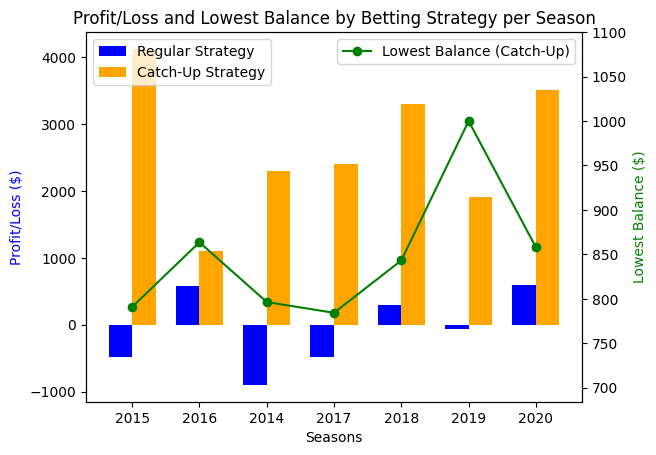

In [11]:
def get_all_team_games(team_name='Barcelona', season=None):
    # Load the dataset
    games_df = pd.read_csv('sample_data/games.csv')
    team_names_df = pd.read_csv('sample_data/teams.csv')
    # league_names_df = pd.read_csv('leagues.csv')

    games_df = games_df.merge(team_names_df, left_on='homeTeamID', right_on='teamID', how='left')
    games_df = games_df.rename(columns={'name': 'homeTeamName'}).drop('teamID', axis=1)
    games_df = games_df.merge(team_names_df, left_on='awayTeamID', right_on='teamID', how='left')
    games_df = games_df.rename(columns={'name': 'awayTeamName'}).drop('teamID', axis=1)

    # Filter for games involving team
    team_games = games_df[
        (games_df['homeTeamName'] == team_name) | (games_df['awayTeamName'] == team_name)].copy()

    # If a specific season is specified, filter for that season
    if season:
        team_games = team_games[team_games['season'] == season]

    return team_games


def calculate_betting_profitability(team_name='Barcelona', season=2020, bet_amount=100):
    games_season = get_all_team_games(team_name, season).sort_values(by='date')

    # Apply functions to determine actual and expected outcomes
    games_season['ActualOutcome'] = games_season.apply(determine_actual_outcome, axis=1)
    games_season['ExpectedOutcome'] = games_season.apply(determine_expected_outcome, axis=1)

    total_profit = 0

    for index, row in games_season.iterrows():
        # Split bet amount based on odds for Draw and Win (Home or Away)
        if row['homeTeamName'] == team_name:
            # Bet against Barcelona (Bet on Draw or Away win)
            draw_bet_amount = bet_amount * (row['B365A'] / (row['B365D'] + row['B365A']))
            away_bet_amount = bet_amount * (row['B365D'] / (row['B365D'] + row['B365A']))
            if row['ActualOutcome'] == 'A':
                profit = (row['B365A'] * away_bet_amount) - bet_amount
            elif row['ActualOutcome'] == 'D':
                profit = (row['B365D'] * draw_bet_amount) - bet_amount
            else:
                profit = -bet_amount
        else:
            # Bet against Barcelona (Bet on Draw or Home win)
            draw_bet_amount = bet_amount * (row['B365D'] / (row['B365D'] + row['B365H']))
            home_bet_amount = bet_amount * (row['B365H'] / (row['B365D'] + row['B365H']))
            if row['ActualOutcome'] == 'H':
                profit = (row['B365H'] * home_bet_amount) - bet_amount
            elif row['ActualOutcome'] == 'D':
                profit = (row['B365D']  * draw_bet_amount) - bet_amount
            else:
                profit = -bet_amount

        total_profit += profit
        # print(f"Date: {row['date']}, Actual Outcome: {row['ActualOutcome']}, Expected Outcome: {row['ExpectedOutcome']}, Profit: {profit}, Total Profit: {total_profit}")

    return total_profit


def calculate_catchup_profitability(team_name='Barcelona', season=2020, initial_bet=100, desired_profit=100, starting_balance=1000):
    games_season = get_all_team_games(team_name, season).sort_values(by='date')

    # Apply functions to determine actual and expected outcomes
    games_season['ActualOutcome'] = games_season.apply(determine_actual_outcome, axis=1)
    games_season['ExpectedOutcome'] = games_season.apply(determine_expected_outcome, axis=1)

    total_profit = 0
    total_losses = 0
    current_bet = initial_bet
    balance = starting_balance
    lowest_balance = starting_balance

    for index, row in games_season.iterrows():
        # Calculate the bet amount using the catch-up strategy formula
        if total_losses > 0:
            odds = row['B365D'] if row['ActualOutcome'] == 'D' else (row['B365A'] if row['homeTeamName'] == team_name else row['B365H'])
            current_bet = (desired_profit + total_losses) / (odds - 1)

        # Ensure the bet does not exceed the current balance
        current_bet = min(current_bet, balance)

        # Calculate the potential profit or loss
        if row['homeTeamName'] == team_name:
            # Bet against Barcelona (Bet on Draw or Away win)
            if row['ActualOutcome'] in ['A', 'D']:
                profit = (current_bet * (row['B365D'] if row['ActualOutcome'] == 'D' else row['B365A'])) - current_bet
            else:
                profit = -current_bet
        else:
            # Bet against Barcelona (Bet on Draw or Home win)
            if row['ActualOutcome'] in ['H', 'D']:
                profit = (current_bet * (row['B365D'] if row['ActualOutcome'] == 'D' else row['B365H'])) - current_bet
            else:
                profit = -current_bet

        # Update the balance, total profit, losses, and lowest balance
        balance += profit
        total_profit += profit
        if profit < 0:
            total_losses += -profit
        else:
            total_losses = 0
            current_bet = initial_bet  # Reset the bet after a win

        # Update lowest balance if needed
        if balance < lowest_balance:
            lowest_balance = balance

        # Optional: Print each game's outcome, profit, and balance
        # print(f"Date: {row['date']}, Actual Outcome: {row['ActualOutcome']}, Profit: {profit}, Total Profit: {total_profit}, Balance: {balance}, Next Bet: {current_bet}")

    return total_profit, lowest_balance

regular_profit_loss = []
catchup_profit_loss = []
lowest_balances = []
for season in seasons:
    season_profit = calculate_betting_profitability(team_name=team_name, season=season, bet_amount=100)
    season_profit_with_catch_up, lowest_balance = calculate_catchup_profitability(team_name=team_name, season=season, initial_bet=100)
    regular_profit_loss.append(season_profit)
    catchup_profit_loss.append(season_profit_with_catch_up)
    lowest_balances.append(lowest_balance)
    print(f"Total Profit/Loss for betting against {team_name} in season {season}: ${season_profit}, with catch-up "
          f"strategy: ${season_profit_with_catch_up}, lowest balance: ${lowest_balance}")
plot_profit_loss_chart(seasons, regular_profit_loss, catchup_profit_loss, lowest_balances)